In [2]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [5]:
starting_exp = 4072
ending_exp = 4107
save_processed_data = True
exp_lists_preformatted = ['4000_4035.csv', '4072_4107.csv'] # Existing formatted datasets
# exp_lists_preformatted = []


experiments = range(starting_exp, ending_exp + 1)

exp_agent_data = []

agg_counts = []

# REMOVE THIS
#algos = ['DQN', 'PPO', 'CMA', 'ODT']

if len(exp_lists_preformatted) == 0:
    for ind, exp_num in enumerate(experiments):
        config_fname = f'./Exp_{exp_num}/config.yaml'
        
        c = load_config_file(config_fname)
        nn_c = c['nn_hyperparameters']
        federated_c = c['federated_learning_settings']
        algo_c = c['algorithm_settings']
        env_c = c['environment_settings']
        eval_c = c['eval_config']
        cma_c = c['cma_parameters']
    
        ev_info = []
    
        seed = env_c['seed']
    
        algorithm_dm = algo_c['algorithm']
        
        def load_from_json_with_error_handling(filepath, columns_specific):
            try:
                return read_csv_data(filepath, columns=columns_specific)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                return None  # Handle the error and return None or an empty object
        
        
        path_list = [
            f"/storage_1/metrics/Exp_{exp_num}", # for Huron
            f"/mnt/storage_1/merl/metrics/Exp_{exp_num}", #for Aulavic
            f"../metrics/Exp_{exp_num}", # neither on storage
        ]

        d_base = None
        for path in path_list:
            if os.path.exists(path):
                d_base = path
                break
                
        base_path = f"{d_base}/train/metrics"
    
        print(f'Loading {base_path}_agent_metrics.csv')
        agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv', ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward',])
        
        agent_data['seed'] = seed
        agent_data['exp_num'] = exp_num
        
        agent_data['algorithm'] = algorithm_dm
        # agent_data['algorithm'] = algos[ind % len(algos)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
        
        agent_data['season'] = env_c['season']
        agent_data['num_aggs'] = federated_c['aggregation_count']
        agent_data['eps_per_agg'] = cma_c['max_generations'] if algorithm_dm == 'CMA' else nn_c['num_episodes']
    
        exp_agent_data.append(agent_data)

Loading /mnt/storage_1/merl/metrics/Exp_360/train/metrics_agent_metrics.csv
Loading /mnt/storage_1/merl/metrics/Exp_361/train/metrics_agent_metrics.csv
Loading /mnt/storage_1/merl/metrics/Exp_362/train/metrics_agent_metrics.csv
Loading /mnt/storage_1/merl/metrics/Exp_363/train/metrics_agent_metrics.csv
Loading /mnt/storage_1/merl/metrics/Exp_364/train/metrics_agent_metrics.csv
Loading /mnt/storage_1/merl/metrics/Exp_365/train/metrics_agent_metrics.csv


In [4]:
if len(exp_lists_preformatted) == 0:
    # Convert data to DataFrame for easier manipulation
    df_agent = pd.concat(exp_agent_data, ignore_index=True)
    
    cumulative_agent_df = (
        df_agent
        .groupby(
            ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'num_aggs', 'eps_per_agg']
        )['reward']
        .sum()
        .reset_index()
    )
    
    # Rename the 'reward' column to 'cumulative_reward' for clarity
    cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)
    
    # Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
    cumulative_agent_df['episode'] = cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']
    
    cumulative_agent_df.head()

In [5]:
# Define the file path with starting_exp and ending_exp variables
file_path_for_processed_data = f'../../../../storage_1/metrics/formatted_experiment_data/part_1/'

if len(exp_lists_preformatted) == 0:
    cumulative_avg_reward_by_algorithm = (
        cumulative_agent_df
        .groupby(['episode', 'algorithm', 'seed', 'num_aggs', 'season'])['cumulative_reward']
        .mean()
        .reset_index()
    )
    
    cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
        ['season', 'algorithm', 'seed', 'num_aggs', 'episode']
    )
    
    cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
        cumulative_avg_reward_by_algorithm
        .groupby(['algorithm', 'seed', 'num_aggs', 'season'])['cumulative_reward']
        .transform(lambda x: x.expanding().mean())
    )

    if save_processed_data:
        if not os.path.exists(file_path_for_processed_data):
            os.makedirs(file_path_for_processed_data)
        
        # Save the DataFrame to a CSV file
        cumulative_avg_reward_by_algorithm.to_csv(f"{file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv", index=False)
        
        print(f"Data successfully saved to {file_path_for_processed_data}/{starting_exp}_{ending_exp}.csv")

if len(exp_lists_preformatted) > 0:
    dataframes = []
    
    # Load and combine datasets
    for existing_set in exp_lists_preformatted:
        loaded_dataset = pd.read_csv(f"{file_path_for_processed_data}/{existing_set}")
        # Combine datasets
        dataframes.append(loaded_dataset)

    cumulative_avg_reward_by_algorithm = pd.concat(dataframes, ignore_index=True)

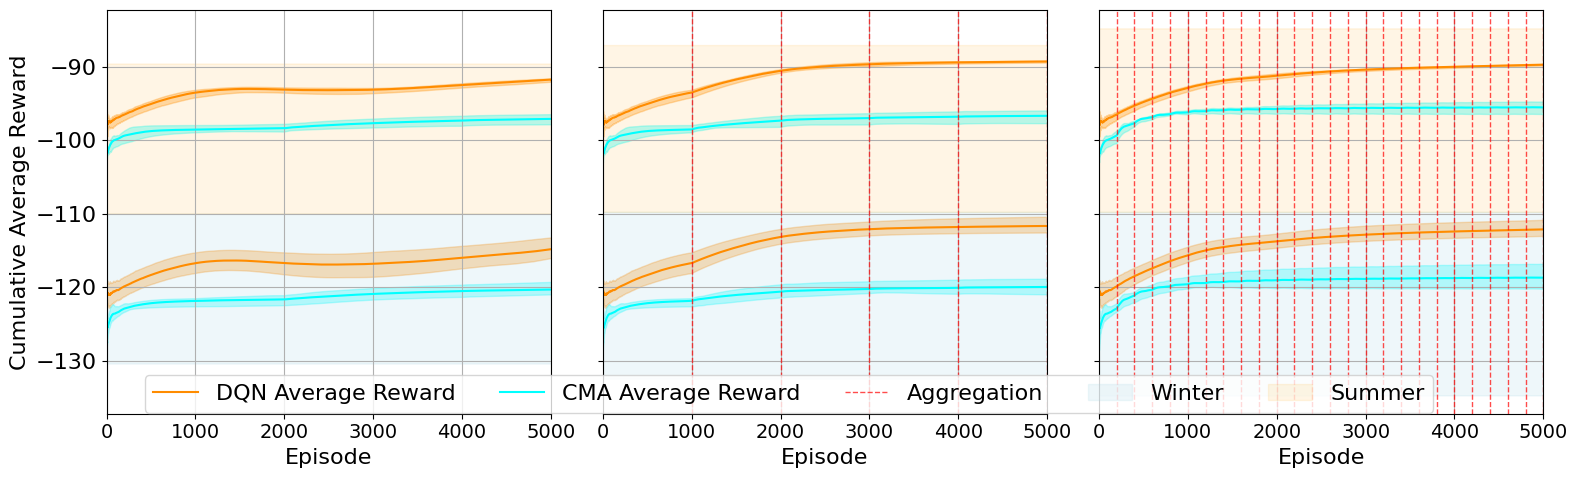

In [8]:
cumulative_avg_reward_by_algorithm['num_aggs'] = np.where(
    (cumulative_avg_reward_by_algorithm['num_aggs'] == 3) & 
    (cumulative_avg_reward_by_algorithm['algorithm'] == 'CMA'), 
    1, 
    cumulative_avg_reward_by_algorithm['num_aggs']
)

# Initialize lists to store legend handles and labels
algorithm_handles = []
algorithm_labels = []
algorithms_added = set()

# Begin plotting
agg_levels_sorted = sorted(cumulative_avg_reward_by_algorithm['num_aggs'].unique(), reverse=False)
num_plots = len(agg_levels_sorted)
fig, axes = plt.subplots(1, num_plots, figsize=(16, 5), sharey=True, sharex=True)

# Set global font size
plt.rcParams.update({
    'font.size': 14,             # Base font size
    'axes.titlesize': 16,        # Font size for axes titles
    'axes.labelsize': 16,        # Font size for x and y labels
    'xtick.labelsize': 14,       # Font size for x-axis ticks
    'ytick.labelsize': 16,       # Font size for y-axis ticks
    'legend.fontsize': 16,       # Font size for legend text
    'figure.titlesize': 18       # Font size for figure titles
})

axes = np.atleast_1d(axes)

for plot_ind, agg_level in enumerate(agg_levels_sorted):
    ax = axes[plot_ind]
    
    agg_level_data = cumulative_avg_reward_by_algorithm.loc[
        cumulative_avg_reward_by_algorithm['num_aggs'] == agg_level
    ]

    total_eps = agg_level_data['episode'].max()
    eps_per_agg = np.ceil(total_eps / agg_level)

    for season in agg_level_data['season'].unique():
        season_data = agg_level_data[agg_level_data['season'] == season]
        
        for algo in season_data['algorithm'].unique():
            # Filter the data for the current algorithm
            algo_data = season_data[season_data['algorithm'] == algo]
            
            min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
            max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
            mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
        
            ax.fill_between(
                min_cumulative_avg_reward.index, 
                min_cumulative_avg_reward.values, 
                max_cumulative_avg_reward.values,
                color=colors[algo],
                alpha=0.3
            )
            # Plot the mean cumulative average reward
            line, = ax.plot(
                mean_cumulative_avg_reward.index, 
                mean_cumulative_avg_reward.values,
                color=colors[algo]
            )
            
            # Collect algorithm handles and labels if not already added
            if algo not in algorithms_added:
                algorithm_handles.append(line)
                algorithm_labels.append(f'{algo} Average Reward')
                algorithms_added.add(algo)

    # Plot aggregation lines
    for agg in range(1, agg_level + 1):
        if agg == 1:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1, alpha=0.7)
        else:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1, alpha=0.7)

    # Shade the seasons across the entire x-axis range
    x_min, x_max = ax.get_xlim()
    x_values = np.linspace(x_min, x_max, num=1000)
    y_min, y_max = ax.get_ylim()
    y_mid = (y_max + y_min) / 2  # Midpoint of y-axis for shading

    # Create shading for seasons
    winter_shade = ax.fill_between(
        x=x_values, 
        y1=y_min, 
        y2=y_mid, 
        color='lightblue', 
        alpha=0.2
    )
    summer_shade = ax.fill_between(
        x=x_values, 
        y1=y_mid, 
        y2=y_max, 
        color='orange', 
        alpha=0.1
    )

    # Remove legends from individual subplots
    # We don't call ax.legend() here to prevent individual legends

    ax.set_xlabel('Episode')
    ax.grid(True)
    ax.set_xlim(0, 5000)

# Set the shared y-label
axes[0].set_ylabel('Cumulative Average Reward')

# Create custom legend entries for seasons
winter_handle = Patch(facecolor='lightblue', edgecolor='lightblue', alpha=0.2, label='Winter')
summer_handle = Patch(facecolor='orange', edgecolor='orange', alpha=0.1, label='Summer')

# Create a custom legend entry for aggregation lines
aggregation_handle = Line2D(
    [0], [0], color='r', linestyle='--', linewidth=1, alpha=0.7, label='Aggregation'
)

# Combine all legend handles and labels
handles = algorithm_handles + [aggregation_handle, winter_handle, summer_handle]
labels = algorithm_labels + ['Aggregation', 'Winter', 'Summer']

# Place the legend outside of the subplots
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, 0.13))

# Adjust layout to make room for the legend
fig.tight_layout(rect=[0, 0, 1, 1])

fig.savefig('./Figures/aggregation_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

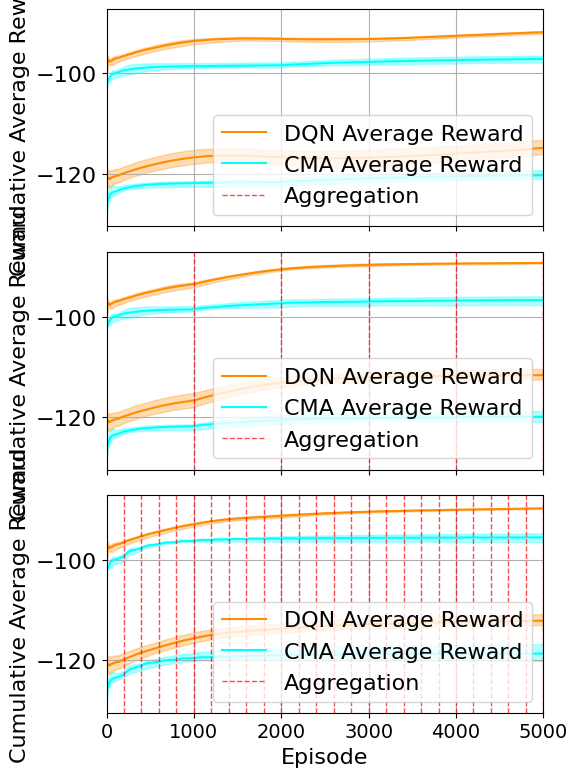

In [7]:
cumulative_avg_reward_by_algorithm['num_aggs'] = np.where(
    (cumulative_avg_reward_by_algorithm['num_aggs'] == 3) & 
    (cumulative_avg_reward_by_algorithm['algorithm'] == 'CMA'), 
    1, 
    cumulative_avg_reward_by_algorithm['num_aggs']
)

agg_levels_sorted = sorted(cumulative_avg_reward_by_algorithm['num_aggs'].unique(), reverse=False)

num_plots = len(cumulative_avg_reward_by_algorithm['num_aggs'].unique())

fig, axes = plt.subplots(num_plots, 1, figsize=(6, 8), sharey=True, sharex=True)  # Adjust figsize as needed

for plot_ind, agg_level in enumerate(agg_levels_sorted):
    ax = axes[plot_ind]
    
    agg_level_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['num_aggs'] == agg_level]

    total_eps = agg_level_data['episode'].max()
    eps_per_agg = np.ceil(total_eps / agg_level)

    for season in agg_level_data['season'].unique():
        season_data = agg_level_data[agg_level_data['season'] == season]
        
        for algo in season_data['algorithm'].unique():
            # Filter the data for the current zone
            algo_data = season_data[season_data['algorithm'] == algo]
            
            min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
            max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
            mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
        
            ax.fill_between(
                min_cumulative_avg_reward.index, 
                min_cumulative_avg_reward.values, 
                max_cumulative_avg_reward.values,
                color=colors[algo],
                alpha=0.3
            )
            if season == 'summer':
                ax.plot(
                    mean_cumulative_avg_reward.index, 
                    mean_cumulative_avg_reward.values,
                    color=colors[algo],
                    label=f'{algo} Average Reward'
                )
            else:
                ax.plot(
                    mean_cumulative_avg_reward.index, 
                    mean_cumulative_avg_reward.values,
                    color=colors[algo]
                )

    for agg in range(1, agg_level + 1):
        if agg == 1:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1, label='Aggregation', alpha=0.7)
        else:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1, alpha=0.7)
    
    axes[-1].set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.legend(loc='lower right')
    ax.grid(True)
    ax.set_xlim(0, 5000)

fig.tight_layout()
fig.show()